__Skip Connection / Bottleneck Skip connection__

![image](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F99F0453F5C47F1741338F0)

- ResNet50 부터는 연산량의 줄이기 위해 Residual Block 내에, 1x1, 3x3, 1x1 컨볼루션 연산을 쌓았다. Inception에서 배웠던 것과 같은 개념이다. 1x1 컨볼루션 연산으로 피쳐맵의 갯수를 줄였다가 3x3을 거친 후, 1x1 컨볼루션 연산으로 차원을 늘려준다. 이 과정이 병목 같다 하여 병목레이어(bottleneck layer)라고 부른다.

__Residual Block / Identity Block__

![image](https://datascienceschool.net/upfiles/2e104ff279804e839cef46fc58ef16e7.png)

-  이미지가 반으로 작아진 경우, Identity Block이 사용되며, 입력값을 바로 더하지 않고, 1x1 컨볼루션 연산을 스트라이드 2로 설정하여 피쳐맵의 크기와 갯수를 맞추어준 다음 더해준다. 이를 프로젝션 숏컷(projection shortcut)

__ResNet Structrue by layer__

![image](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99167C335C47F0E315)

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# modules setting

import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime

In [2]:
def one_hot(data, classes, nb_classes = 2):
    one_hot = [0]*nb_classes
    one_hot[classes] = 1
    return np.vstack([one_hot for i in range(len(data))])

def random_minibatch(x, y, batch_size = 50):
    idx = np.random.choice(len(x), batch_size)
    return x[idx], y[idx]

def shuffle(x, y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    if type(x) == type(y):
        return x[idx], y[idx] 
    else:
        return x[idx]
    
def history(save = False):
    fig = plt.figure(figsize = (15,20))
    plt.suptitle('Training History', y = 0.92, fontsize = 20)
    
    x_axis = range(1, len(accr_train)+1)
    
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, accr_train, 'b-', label = 'Training Accuracy')
    plt.plot(x_axis, accr_valid, 'r-', label = 'Validation Accuracy')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.subplot(2, 1, 2)
    plt.plot(x_axis, loss_train, 'b-', label = 'Training Loss')
    plt.plot(x_axis, loss_valid, 'r-', label = 'Validation Loss')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
#     plt.yticks(np.arange(0, 0.25, step=0.025))
    plt.legend(fontsize = 12)
    plt.show()
    if save == True:
        fig.savefig(hist_path + filename)
        plt.close(fig)

In [3]:
class Contents:
    def table(self):
        print('==============================================================')
        print('[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss')
        print('==============================================================')
    def evl(self):
        evl = '[{0:*>4d}] || {1:*>.2f} %    || {2:*>.2f} %    || {3:.8f} || {4:.8f}'.format(n_iter, 
                                                                                      accr_train[-1]*100, accr_valid[-1]*100, 
                                                                                      loss_train[-1], loss_valid[-1])
        return evl
    def prt_evl(self):
        print(self.evl())
        print('--------------------------------------------------------------')
    def early_under(self):
        print(self.evl() + ' [Early stopping - Underffiting !!]\n')
    def early_over(self):
        print(self.evl() + ' [Early stopping - Overffiting !!]\n')
    def early(self):
        print(self.evl() + ' [Early stopping]\n')
    def done(self):  
        global training_name
        global contents
        global filename
        global title
        
        now = datetime.datetime.now()
        nowDatetime = now.strftime('%y%m%d%H%M')
        
        contents = (
        'Training Time : {} Min.\n'.format(train_time) +
        'Early Stopping : {}\n'.format(early_stopping) +
        'Iteration : {}\n'.format(n_iter)
        )
        print(contents)

        title = '[ResNet-50] Training History'

# Load Data

In [8]:
train_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/HHT/lin/train'
npy_files = os.listdir(train_dir)
npy_files

['ball_7.npy',
 'ball_14.npy',
 'ball_21.npy',
 'inner_7.npy',
 'inner_14.npy',
 'inner_21.npy',
 'outer_7.npy',
 'outer_14.npy',
 'outer_21.npy',
 'normal.npy']

In [9]:
normal = np.load(os.path.join(train_dir, str([i for i in npy_files if 'normal' in i][0])))
ball_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_7' in i][0])))
ball_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_14' in i][0])))
ball_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_21' in i][0])))
inner_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_7' in i][0])))
inner_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_14' in i][0])))
inner_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_21' in i][0])))
outer_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_7' in i][0])))
outer_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_14' in i][0])))
outer_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_21' in i][0])))

normal_y = one_hot(normal, 0, nb_classes = 10)
ball_7_y = one_hot(ball_7, 1, nb_classes = 10)
ball_14_y = one_hot(ball_14, 2, nb_classes = 10)
ball_21_y = one_hot(ball_21, 3, nb_classes = 10)
inner_7_y = one_hot(inner_7, 4, nb_classes = 10)
inner_14_y = one_hot(inner_14, 5, nb_classes = 10)
inner_21_y = one_hot(inner_21, 6, nb_classes = 10)
outer_7_y = one_hot(outer_7, 7, nb_classes = 10)
outer_14_y = one_hot(outer_14, 8, nb_classes = 10)
outer_21_y = one_hot(outer_21, 9, nb_classes = 10)

print("normal:", normal.shape, normal_y.shape)
print("ball_7:", ball_7.shape, ball_7_y.shape)
print("ball_14:", ball_14.shape, ball_14_y.shape)
print("ball_21:", ball_21.shape, ball_21_y.shape)
print("inner_7:", inner_7.shape, inner_7_y.shape)
print("inner_14:", inner_14.shape, inner_14_y.shape)
print("inner_21:", inner_21.shape, inner_21_y.shape)
print("outer_7:", outer_7.shape, outer_7_y.shape)
print("outer_14:", outer_14.shape, outer_14_y.shape)
print("outer_21:", outer_21.shape, outer_21_y.shape)

normal: (750, 100, 100, 6) (750, 10)
ball_7: (750, 100, 100, 6) (750, 10)
ball_14: (750, 100, 100, 6) (750, 10)
ball_21: (750, 100, 100, 6) (750, 10)
inner_7: (750, 100, 100, 6) (750, 10)
inner_14: (750, 100, 100, 6) (750, 10)
inner_21: (750, 100, 100, 6) (750, 10)
outer_7: (750, 100, 100, 6) (750, 10)
outer_14: (750, 100, 100, 6) (750, 10)
outer_21: (750, 100, 100, 6) (750, 10)


# Data split

In [10]:
def train_valid_split(data, label, train_rate = 0.85):
    train_idx = np.sort(np.random.choice(len(data), round(len(data)*train_rate), replace = False))
    valid_idx = np.setxor1d(train_idx, np.arange(len(data)))
    return data[train_idx], label[train_idx], data[valid_idx], label[valid_idx]

In [11]:
normal_train_x, normal_train_y, normal_valid_x, normal_valid_y = train_valid_split(normal, normal_y)
print("normal:", normal_train_x.shape, normal_train_y.shape, normal_valid_x.shape, normal_valid_y.shape)

ball_7_train_x, ball_7_train_y, ball_7_valid_x, ball_7_valid_y = train_valid_split(ball_7, ball_7_y)
ball_14_train_x, ball_14_train_y, ball_14_valid_x, ball_14_valid_y = train_valid_split(ball_14, ball_14_y)
ball_21_train_x, ball_21_train_y, ball_21_valid_x, ball_21_valid_y = train_valid_split(ball_21, ball_21_y)
print("ball_7:", ball_7_train_x.shape, ball_7_train_y.shape, ball_7_valid_x.shape, ball_7_valid_y.shape)
print("ball_14:", ball_14_train_x.shape, ball_14_train_y.shape, ball_14_valid_x.shape, ball_14_valid_y.shape)
print("ball_21:", ball_21_train_x.shape, ball_21_train_y.shape, ball_21_valid_x.shape, ball_21_valid_y.shape)

inner_7_train_x, inner_7_train_y, inner_7_valid_x, inner_7_valid_y = train_valid_split(inner_7, inner_7_y)
inner_14_train_x, inner_14_train_y, inner_14_valid_x, inner_14_valid_y = train_valid_split(inner_14, inner_14_y)
inner_21_train_x, inner_21_train_y, inner_21_valid_x, inner_21_valid_y = train_valid_split(inner_21, inner_21_y)
print("inner_7:", inner_7_train_x.shape, inner_7_train_y.shape, inner_7_valid_x.shape, inner_7_valid_y.shape)
print("inner_14:", inner_14_train_x.shape, inner_14_train_y.shape, inner_14_valid_x.shape, inner_14_valid_y.shape)
print("inner_21:", inner_21_train_x.shape, inner_21_train_y.shape, inner_21_valid_x.shape, inner_21_valid_y.shape)

outer_7_train_x, outer_7_train_y, outer_7_valid_x, outer_7_valid_y = train_valid_split(outer_7, outer_7_y)
outer_14_train_x, outer_14_train_y, outer_14_valid_x, outer_14_valid_y = train_valid_split(outer_14, outer_14_y)
outer_21_train_x, outer_21_train_y, outer_21_valid_x, outer_21_valid_y = train_valid_split(outer_21, outer_21_y)
print("outer_7:", outer_7_train_x.shape, outer_7_train_y.shape, outer_7_valid_x.shape, outer_7_valid_y.shape)
print("outer_14:", outer_14_train_x.shape, outer_14_train_y.shape, outer_14_valid_x.shape, outer_14_valid_y.shape)
print("outer_21:", outer_21_train_x.shape, outer_21_train_y.shape, outer_21_valid_x.shape, outer_21_valid_y.shape)

normal: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
ball_7: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
ball_14: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
ball_21: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
inner_7: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
inner_14: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
inner_21: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
outer_7: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
outer_14: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
outer_21: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)


In [12]:
train_X = np.vstack([normal_train_x, ball_7_train_x, ball_14_train_x, ball_21_train_x, 
                     inner_7_train_x, inner_14_train_x, inner_21_train_x,
                     outer_7_train_x, outer_14_train_x, outer_21_train_x, ])
train_Y = np.vstack([normal_train_y, ball_7_train_y, ball_14_train_y, ball_21_train_y, 
                     inner_7_train_y, inner_14_train_y, inner_21_train_y,
                     outer_7_train_y, outer_14_train_y, outer_21_train_y, ])
valid_X = np.vstack([normal_valid_x, ball_7_valid_x, ball_14_valid_x, ball_21_valid_x, 
                     inner_7_valid_x, inner_14_valid_x, inner_21_valid_x,
                     outer_7_valid_x, outer_14_valid_x, outer_21_valid_x, ])
valid_Y = np.vstack([normal_valid_y, ball_7_valid_y, ball_14_valid_y, ball_21_valid_y, 
                     inner_7_valid_y, inner_14_valid_y, inner_21_valid_y,
                     outer_7_valid_y, outer_14_valid_y, outer_21_valid_y, ])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (6380, 100, 100, 6) (6380, 10)
Validation set: (1120, 100, 100, 6) (1120, 10)


# Model

In [13]:
input_h = 100
input_w = 100
input_ch = 6

ch = 16
# 50 50 16

r_ch_1 = 32
# 25 25 32

r_ch_2 = 32
# 12 12 16

r_ch_3 = 64
# 12 12 32

r_ch_4 = 128
# 6 6 128

n_output = 10

In [14]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
batch_prob = tf.placeholder(tf.bool, name = 'bn_prob')

class ResNet50:
    def __init__(self, ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4):
        self.ch = ch
        self.r_ch_1 = r_ch_1
        self.r_ch_2 = r_ch_2
        self.r_ch_3 = r_ch_3
        self.r_ch_4 = r_ch_4
    def conv(self, x, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        conv = tf.layers.conv2d(inputs = x, filters = channel, kernel_size = kernel_size, 
                                strides = strides, padding = "SAME")
        conv = tf.layers.batch_normalization(conv, center=True, scale=True, training=batch_prob)
        if activation == True:
            conv = tf.nn.relu(conv)
        return conv
    
    def maxp(self, conv):
        maxp = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2)
        return maxp

    def res_block(self, x, channel):
        x_shortcut = x
        conv_a = self.conv(x, channel/4, kernel_size = [1, 1])
        conv_b = self.conv(conv_a, channel/4, kernel_size = [3, 3])
        conv_c = self.conv(conv_b, channel, kernel_size = [1, 1])
        return tf.nn.relu(conv_c + x_shortcut)
    
    def id_block(self, x, channel, strides = (2, 2)):
        x_shortcut = x
        conv_2a = self.conv(x, channel/4, kernel_size = [1, 1], strides = strides)
        conv_2b = self.conv(conv_2a, channel/4, kernel_size = [3, 3])
        conv_2c = self.conv(conv_2b, channel, kernel_size = [1, 1], activation = False)
        conv_1 = self.conv(x, channel, kernel_size = [1, 1], strides = strides, activation = False)
        return tf.nn.relu(conv_1 + conv_2c)

    def fc_layer(self, gap, n_output = None):
        flatten = tf.layers.flatten(gap)
        output = tf.layers.dense(inputs = flatten, units = n_output)
        return output

    def global_avg_pooling(self, x):
        gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        return gap

    def res_block_rep(self, x, target_ch, n_rep):
        for _ in range(n_rep):
            x = self.res_block(x, target_ch)
        return x

    def inf(self, x):
        """
        conv_1: 1
        id_~ + resnet_~: 16 x 3 = 48
        fc_lay: 1

        total: 50
        """
        conv_1 = self.conv(x, self.ch, strides = (2, 2))
        maxp_1 = self.maxp(conv_1)
        id_1 = self.id_block(maxp_1, self.r_ch_1, strides = (1, 1))
        res_1 = self.res_block_rep(id_1, self.r_ch_1, n_rep = 2)
        id_2 = self.id_block(res_1,self.r_ch_2, strides = (2, 2))
        res_2 = self.res_block_rep(id_2, self.r_ch_2, n_rep = 3)
        id_3 = self.id_block(res_2, self.r_ch_3, strides = (2, 2))
        res_3 = self.res_block_rep(id_3, self.r_ch_3, n_rep = 5)
        id_4 = self.id_block(res_3, self.r_ch_4, strides = (2, 2))
        res_4 = self.res_block_rep(id_4, self.r_ch_4, n_rep = 2)
        gap = self.global_avg_pooling(res_4)
        score = self.fc_layer(gap, n_output)
        return score

    
model = ResNet50(ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1215 01:08:39.409118 140006771177216 deprecation.py:323] From <ipython-input-14-f95364146dc4>:16: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1215 01:08:39.417003 140006771177216 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1215 01:08:39.725166 140006771177216 deprecation.py:323] From <ipython-input-14-f95364146dc4>:17: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencie

# Training

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 6.25 %    || 10.94 %    || 2.28709078 || 2.40051556
--------------------------------------------------------------
[*200] || 6.25 %    || 7.81 %    || 2.83590794 || 2.66672301
--------------------------------------------------------------
[*300] || 9.38 %    || 12.50 %    || 2.81374049 || 2.69278550
--------------------------------------------------------------


W1215 01:10:01.121863 140006771177216 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*400] || 56.25 %    || 54.69 %    || 1.07556987 || 1.09757137
--------------------------------------------------------------
[*500] || 93.75 %    || 84.38 %    || 0.22374342 || 0.37033355
--------------------------------------------------------------
[*600] || 93.75 %    || 98.44 %    || 0.23835212 || 0.19778381
--------------------------------------------------------------
[*700] || 96.88 %    || 95.31 %    || 0.09935649 || 0.16636077
--------------------------------------------------------------
[*800] || 100.00 %    || 98.44 %    || 0.03509664 || 0.08735838
--------------------------------------------------------------
[*900] || 100.00 %    || 98.44 %    || 0.02635001 || 0.04890753
--------------------------------------------------------------
[1000] || 100.00 %    || 100.00 %    || 0.01595042 || 0.02113478
--------------------------------------------------------------
[1100] || 100.00 %    || 98.44 %    || 0.00745912 || 0.06009222
--------------------------------------------------

[6900] || 100.00 %    || 100.00 %    || 0.00013001 || 0.00021049
--------------------------------------------------------------
[7000] || 100.00 %    || 98.44 %    || 0.00012788 || 0.01484264
--------------------------------------------------------------
[7100] || 100.00 %    || 100.00 %    || 0.00006991 || 0.00011308
--------------------------------------------------------------
[7200] || 100.00 %    || 100.00 %    || 0.00007177 || 0.00011554
--------------------------------------------------------------
[7300] || 100.00 %    || 100.00 %    || 0.00006437 || 0.00012671
--------------------------------------------------------------
[7400] || 100.00 %    || 100.00 %    || 0.00011723 || 0.00014977
--------------------------------------------------------------
[7500] || 100.00 %    || 100.00 %    || 0.00010881 || 0.00011440
--------------------------------------------------------------
[7600] || 100.00 %    || 100.00 %    || 0.00004292 || 0.00043620
----------------------------------------

[13300] || 100.00 %    || 100.00 %    || 0.00002042 || 0.00005339
--------------------------------------------------------------
[13400] || 100.00 %    || 100.00 %    || 0.00017235 || 0.00172724
--------------------------------------------------------------
[13500] || 100.00 %    || 100.00 %    || 0.00006700 || 0.00004763
--------------------------------------------------------------
[13600] || 100.00 %    || 100.00 %    || 0.00002797 || 0.00002842
--------------------------------------------------------------
[13700] || 100.00 %    || 100.00 %    || 0.00002178 || 0.00004131
--------------------------------------------------------------
[13800] || 100.00 %    || 100.00 %    || 0.00004539 || 0.00004142
--------------------------------------------------------------
[13900] || 100.00 %    || 100.00 %    || 0.00002152 || 0.00147243
--------------------------------------------------------------
[14000] || 100.00 %    || 98.44 %    || 0.00002073 || 0.02822652
--------------------------------

[19700] || 100.00 %    || 100.00 %    || 0.00000288 || 0.00000364
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00000437 || 0.00000747
--------------------------------------------------------------
[19900] || 100.00 %    || 100.00 %    || 0.00000998 || 0.00000555
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00000315 || 0.00110966
--------------------------------------------------------------
Training Time : 18 Min.
Early Stopping : False
Iteration : 20000



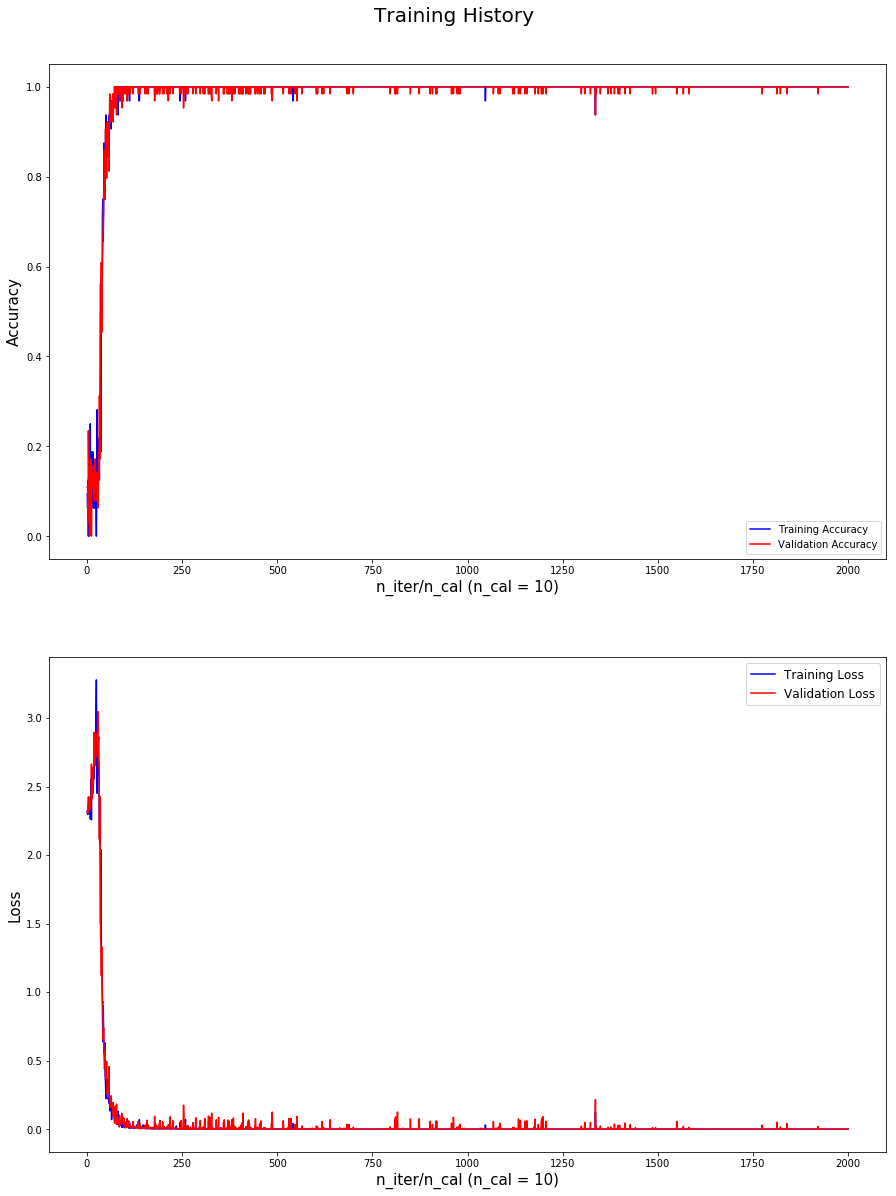

In [15]:
t_batch = 32
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)

lr = 1e-4

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# optm = tf.train.AdamOptimizer(lr).minimize(loss)

con = Contents()

accr_valid = []
loss_valid = []
accr_train = []
loss_train = []

early_stopping = False

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

con.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'bn_prob:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            con.prt_evl()
            
        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'hht_lin_res50_v2_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/HHT/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     con.early_under()
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     con.early_over()
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
con.done()

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_v2_HHT_lin_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_v2_HHT_lin_loss', np.array(loss_train))

history(save = False)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 18.75 %    || 7.81 %    || 2.35035801 || 2.35948610
--------------------------------------------------------------
[*200] || 9.38 %    || 6.25 %    || 2.85670280 || 2.70731640
--------------------------------------------------------------
[*300] || 21.88 %    || 17.19 %    || 2.35240602 || 2.43627119
--------------------------------------------------------------
[*400] || 59.38 %    || 46.88 %    || 1.07459939 || 1.15552640
--------------------------------------------------------------
[*500] || 71.88 %    || 82.81 %    || 0.54941946 || 0.52948135
--------------------------------------------------------------
[*600] || 90.62 %    || 95.31 %    || 0.21781014 || 0.19537219
--------------------------------------------------------------
[*700] || 93.75 %    || 92.19 %    || 0.16372544 || 0.19990657
--------------------------------------------------------------
[*800] || 93.75 %    || 95.31 %    || 0.11093462 || 0.1293

[6400] || 100.00 %    || 100.00 %    || 0.00010842 || 0.00016385
--------------------------------------------------------------
[6500] || 100.00 %    || 100.00 %    || 0.00007600 || 0.00026233
--------------------------------------------------------------
[6600] || 100.00 %    || 100.00 %    || 0.00010727 || 0.00015546
--------------------------------------------------------------
[6700] || 100.00 %    || 100.00 %    || 0.00022844 || 0.00009317
--------------------------------------------------------------
[6800] || 96.88 %    || 95.31 %    || 0.09384145 || 0.12275937
--------------------------------------------------------------
[6900] || 100.00 %    || 100.00 %    || 0.00017547 || 0.00026797
--------------------------------------------------------------
[7000] || 100.00 %    || 98.44 %    || 0.00014714 || 0.01513403
--------------------------------------------------------------
[7100] || 100.00 %    || 100.00 %    || 0.00007805 || 0.00025502
------------------------------------------

[12800] || 100.00 %    || 100.00 %    || 0.00001727 || 0.00003387
--------------------------------------------------------------
[12900] || 100.00 %    || 100.00 %    || 0.00001382 || 0.00003096
--------------------------------------------------------------
[13000] || 100.00 %    || 100.00 %    || 0.00006961 || 0.00002865
--------------------------------------------------------------
[13100] || 100.00 %    || 100.00 %    || 0.00002178 || 0.00001592
--------------------------------------------------------------
[13200] || 100.00 %    || 100.00 %    || 0.00001477 || 0.00000777
--------------------------------------------------------------
[13300] || 100.00 %    || 100.00 %    || 0.00001987 || 0.00001042
--------------------------------------------------------------
[13400] || 100.00 %    || 100.00 %    || 0.00002456 || 0.00004909
--------------------------------------------------------------
[13500] || 100.00 %    || 100.00 %    || 0.00001464 || 0.00002099
-------------------------------

[19200] || 100.00 %    || 100.00 %    || 0.00000496 || 0.00000348
--------------------------------------------------------------
[19300] || 100.00 %    || 100.00 %    || 0.00000234 || 0.00000273
--------------------------------------------------------------
[19400] || 100.00 %    || 100.00 %    || 0.00000360 || 0.00000380
--------------------------------------------------------------
[19500] || 100.00 %    || 100.00 %    || 0.00000210 || 0.00000266
--------------------------------------------------------------
[19600] || 100.00 %    || 100.00 %    || 0.00000253 || 0.00000316
--------------------------------------------------------------
[19700] || 100.00 %    || 100.00 %    || 0.00000295 || 0.00000296
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00000320 || 0.00000500
--------------------------------------------------------------
[19900] || 100.00 %    || 100.00 %    || 0.00000221 || 0.00000342
-------------------------------

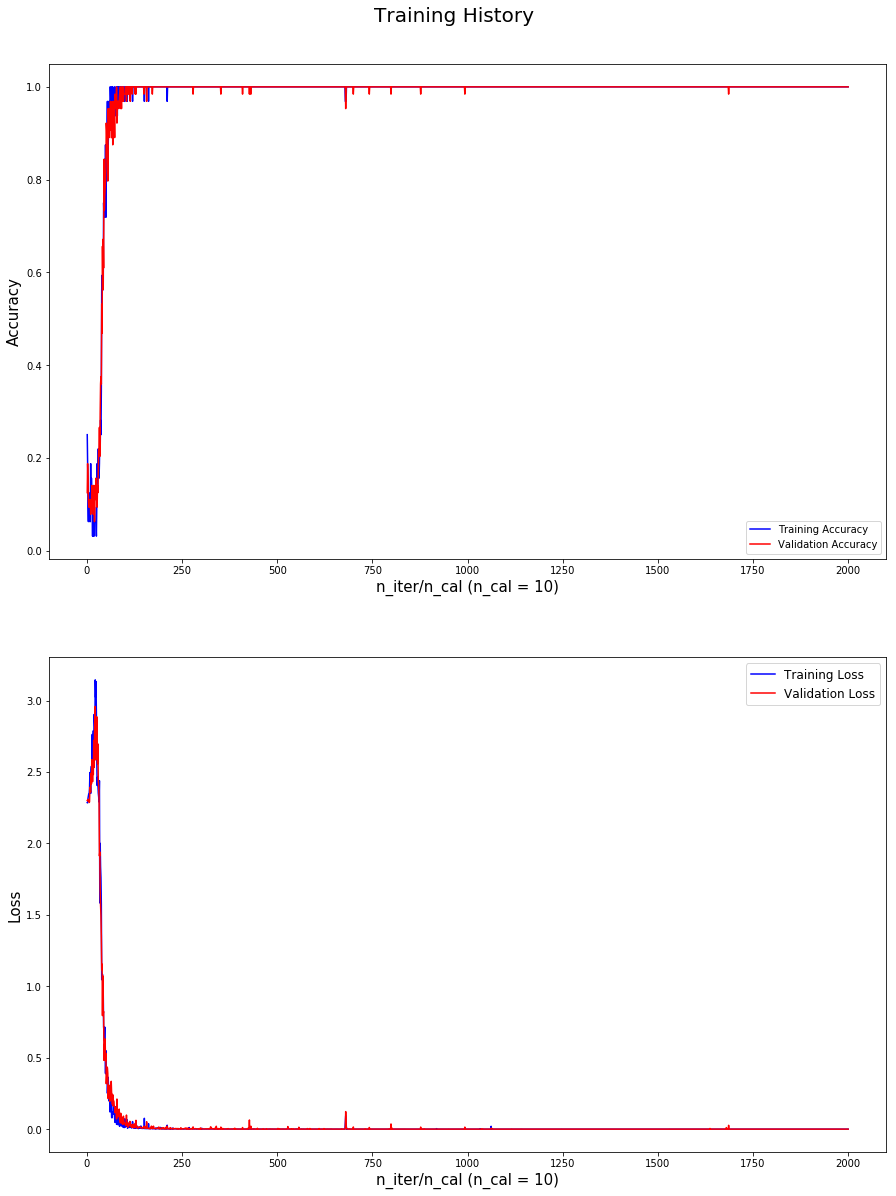

In [44]:
t_batch = 32
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)

lr = 1e-4

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# optm = tf.train.AdamOptimizer(lr).minimize(loss)

con = Contents()

accr_valid = []
loss_valid = []
accr_train = []
loss_train = []

early_stopping = False

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

con.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'bn_prob:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            con.prt_evl()
            
        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'hht_res50_6000_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/HHT/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     con.early_under()
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     con.early_over()
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
con.done()

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_HHT_6000_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_HHT_6000_loss', np.array(loss_train))

history(save = False)   

# sess.close()